# Time Series Regression Models

## The Linear Model

### Simple Linear Regression

In [3]:
library(fpp3)
options(repr.plot.width=12, repr.plot.height=6)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── fpp3 0.4.0 ──

✔ tibble      3.1.7     ✔ tsibble     1.1.1
✔ dplyr       1.0.9     ✔ tsibbledata 0.4.0
✔ tidyr       1.2.0     ✔ feasts      0.2.2
✔ lubridate   1.8.0     ✔ fable       0.3.1
✔ ggplot2     3.3.6     

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── fpp3_conflicts ──
✖ lubridate::date()    masks base::date()
✖ dplyr::filter()      masks stats::filter()
✖ tsibble::intersect() masks base::intersect()
✖ tsibble::interval()  masks lubridate::interval()
✖ dplyr::lag()         masks stats::lag()
✖ tsibble::setdiff()   masks base::setdiff()
✖ tsibble::union()     masks base::union()



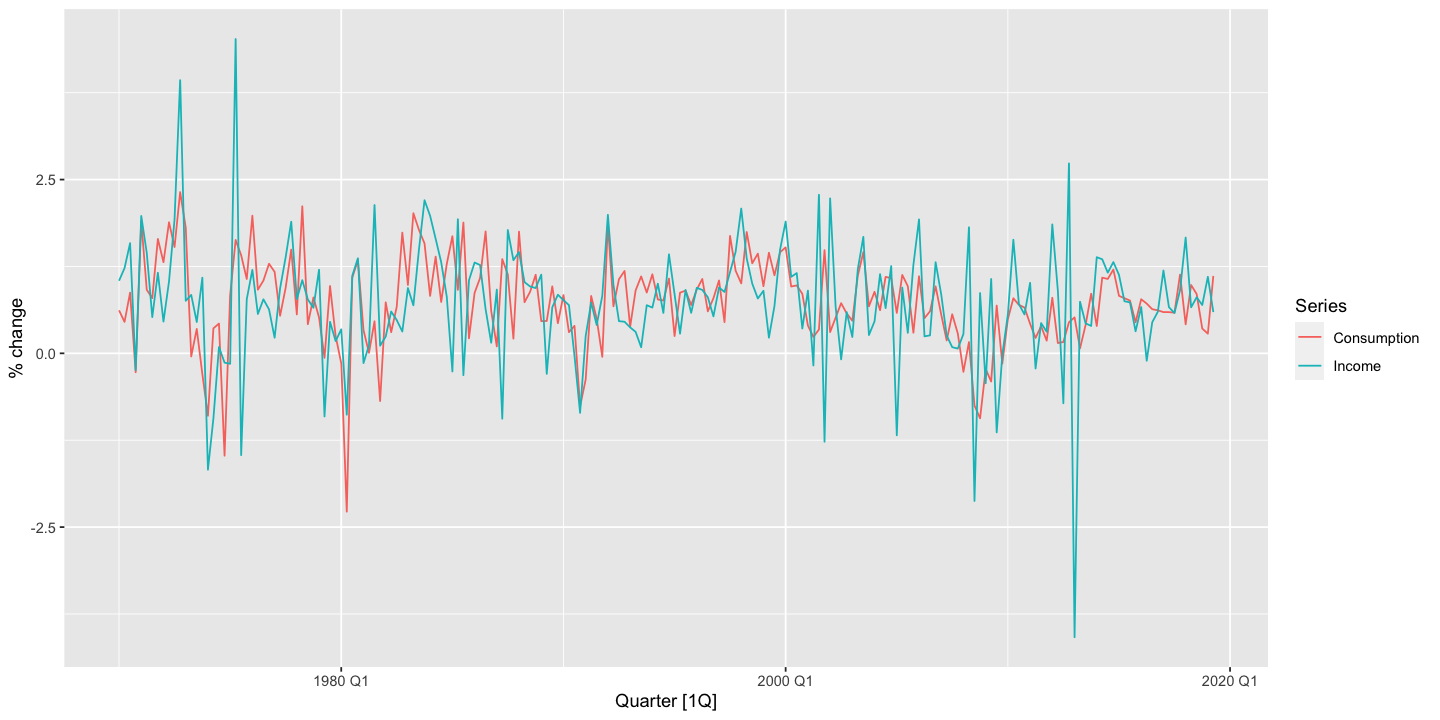

In [4]:
us_change %>%
  pivot_longer(c(Consumption, Income), names_to="Series") %>%
  autoplot(value) +
  labs(y="% change")

`geom_smooth()` using formula 'y ~ x'



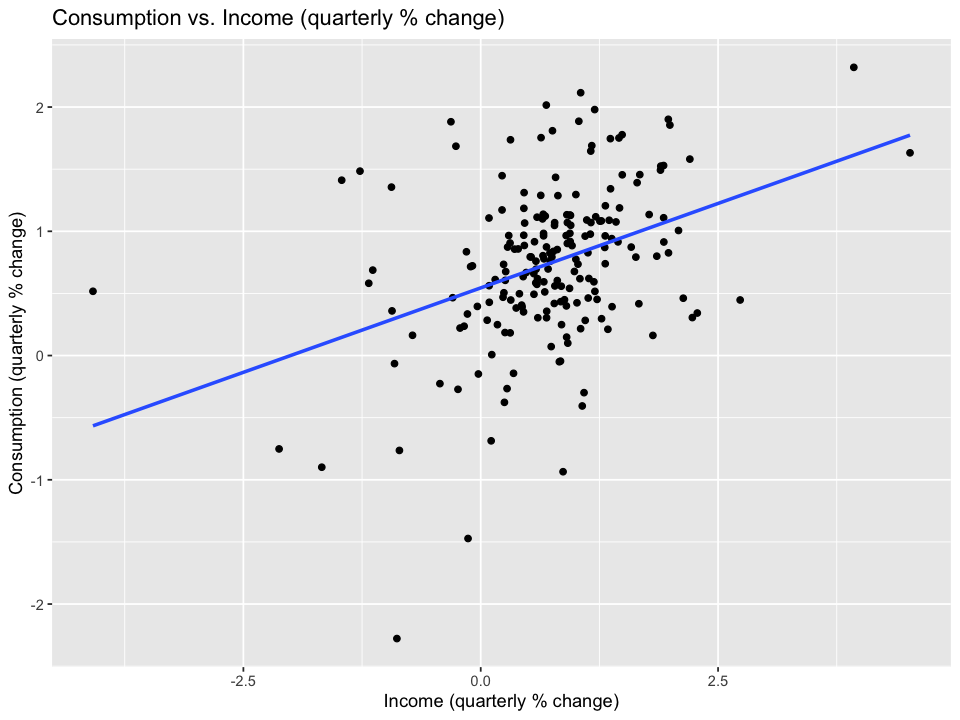

In [5]:
options(repr.plot.width=8, repr.plot.height=6)

us_change %>%
  ggplot(aes(x=Income, y=Consumption)) +
  labs(title="Consumption vs. Income (quarterly % change)",
       y="Consumption (quarterly % change)",
       x="Income (quarterly % change)") +
  geom_point() +
  geom_smooth(method="lm", se=FALSE)

In [6]:
us_change %>%
  model(TSLM(Consumption ~ Income)) %>%
  report()

Series: Consumption 
Model: TSLM 

Residuals:
     Min       1Q   Median       3Q      Max 
-2.58236 -0.27777  0.01862  0.32330  1.42229 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.54454    0.05403  10.079  < 2e-16 ***
Income       0.27183    0.04673   5.817  2.4e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5905 on 196 degrees of freedom
Multiple R-squared: 0.1472,	Adjusted R-squared: 0.1429
F-statistic: 33.84 on 1 and 196 DF, p-value: 2.4022e-08


 ### Multiple Linear Regression

#### Example: US Consumption Expenditure

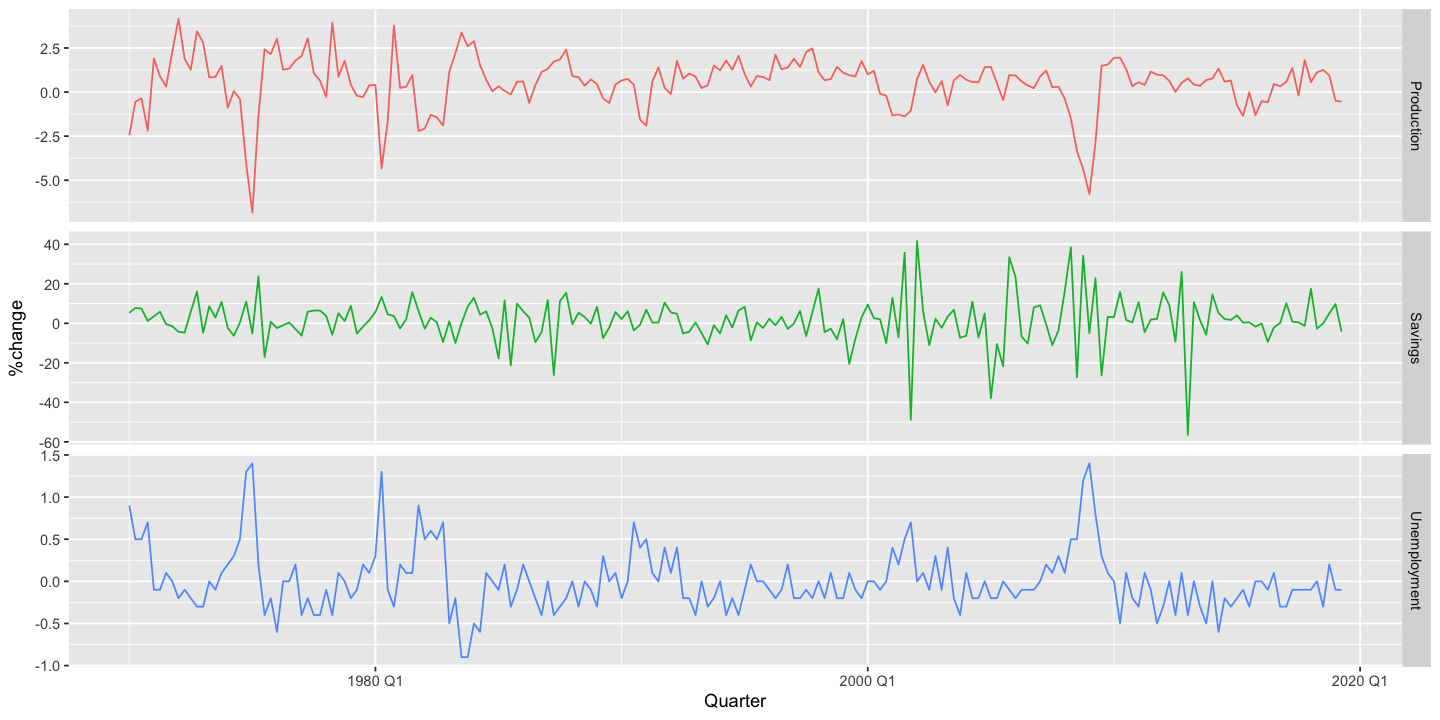

In [8]:
options(repr.plot.width=12, repr.plot.height=6)

us_change %>%
  select(-Consumption, -Income) %>%
  pivot_longer(-Quarter) %>%
  ggplot(aes(Quarter, value, colour=name)) +
  geom_line() +
  facet_grid(name~., scales="free_y") +
  guides(colour="none") +
  labs(y="%change")

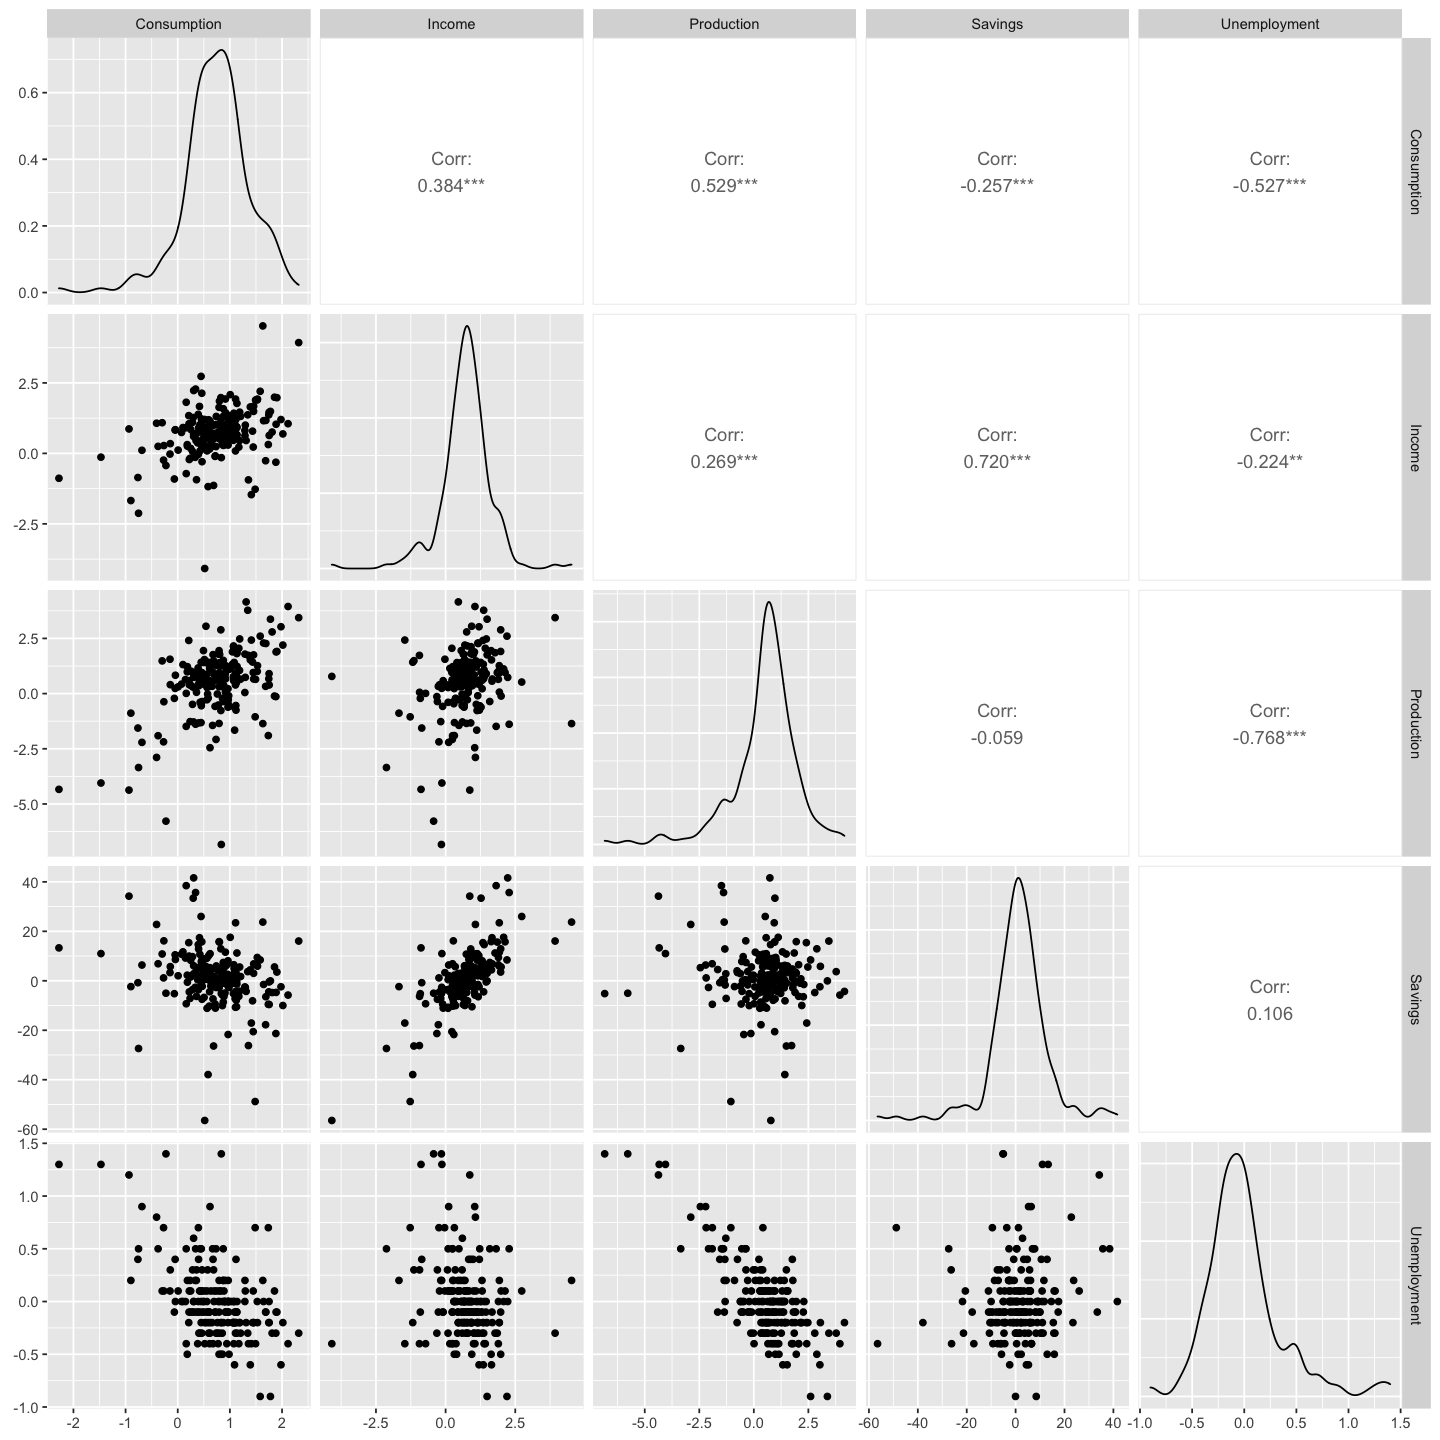

In [12]:
options(repr.plot.width=12, repr.plot.height=12)

us_change %>%
  GGally::ggpairs(columns=2:6)

## Least Squares Estimation

### Example: US Consumption Expenditure

In [13]:
fit_consMR <- us_change %>%
  model(tslm=TSLM(Consumption~Income+Production+Unemployment+Savings))
report(fit_consMR)

Series: Consumption 
Model: TSLM 

Residuals:
     Min       1Q   Median       3Q      Max 
-0.90555 -0.15821 -0.03608  0.13618  1.15471 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.253105   0.034470   7.343 5.71e-12 ***
Income        0.740583   0.040115  18.461  < 2e-16 ***
Production    0.047173   0.023142   2.038   0.0429 *  
Unemployment -0.174685   0.095511  -1.829   0.0689 .  
Savings      -0.052890   0.002924 -18.088  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3102 on 193 degrees of freedom
Multiple R-squared: 0.7683,	Adjusted R-squared: 0.7635
F-statistic:   160 on 4 and 193 DF, p-value: < 2.22e-16


### Fitted Values

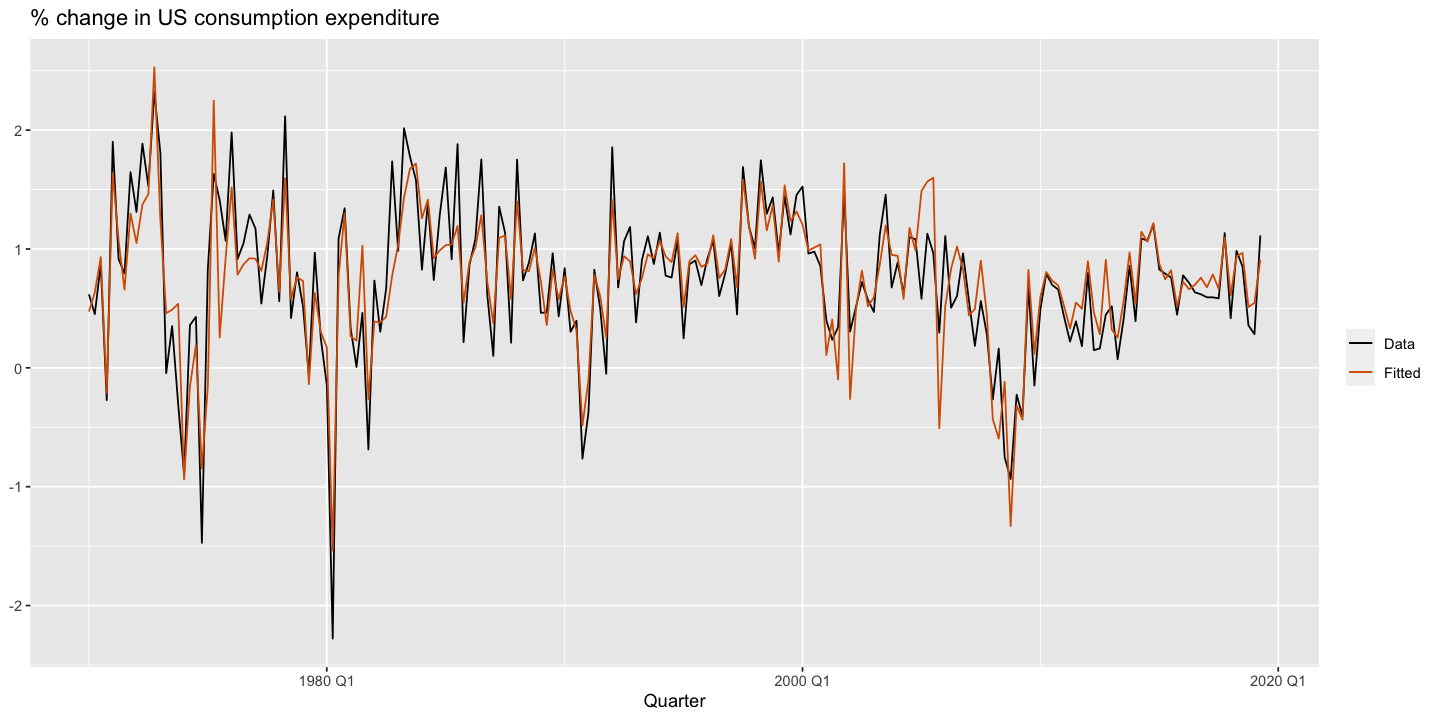

In [15]:
options(repr.plot.width=12, repr.plot.height=6)

augment(fit_consMR) %>%
  ggplot(aes(x=Quarter)) +
  geom_line(aes(y=Consumption, colour="Data")) +
  geom_line(aes(y=.fitted, colour="Fitted")) +
  labs(y=NULL,
       title="% change in US consumption expenditure") +
  scale_colour_manual(values=c(Data="black", Fitted="#D55E00")) +
  guides(colour=guide_legend(title=NULL))

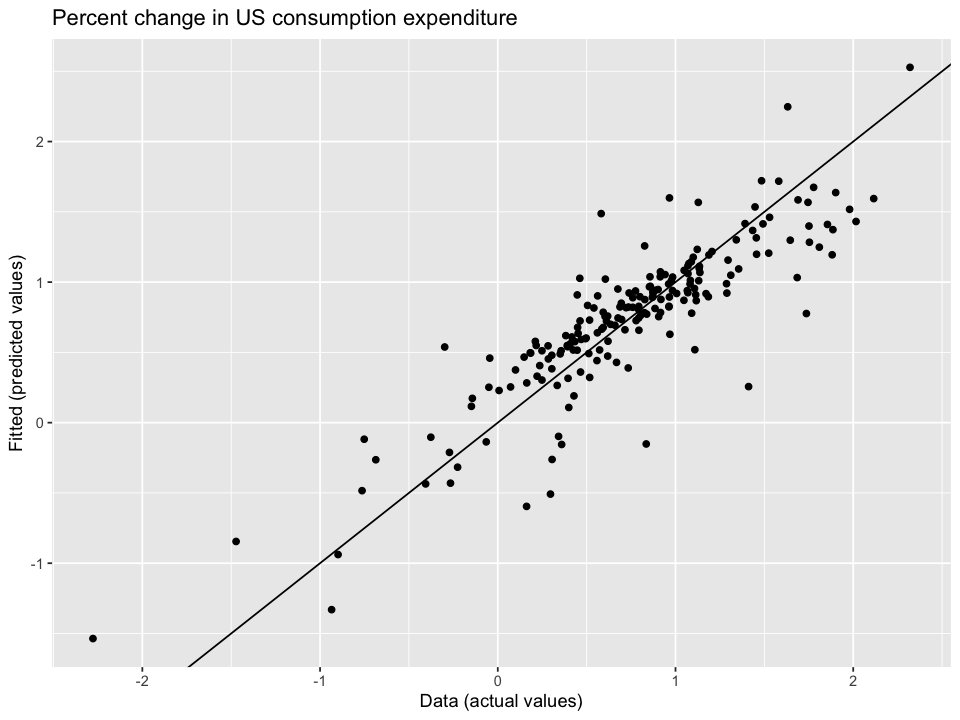

In [20]:
options(repr.plot.width=8, repr.plot.height=6)

augment(fit_consMR) %>%
  ggplot(aes(x=Consumption, y=.fitted)) +
  geom_point() +
  labs(y="Fitted (predicted values)",
        x="Data (actual values)",
        title="Percent change in US consumption expenditure") +
  geom_abline(intercept=0, slope=1)

### Goodness of Fit